# CS5242

## Load Data

In [1]:
from data import Data

train_data = Data(data_type='train')
test_data = Data(data_type='test')

print("Train data: x:"+ str(train_data.x.shape)+ ' y:'+str(train_data.y.shape))
print("Test data: x:"+ str(test_data.x.shape)+ ' y:'+str(test_data.y.shape))



Loading train data 18662/18662: 100%|█████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Loading test data 6051/6051: 100%|████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Train data: x:(18662, 1000, 102) y:(18662, 1)
Test data: x:(6051, 1000, 102) y:(6051, 1)


## Model

In [2]:
import tensorflow as tf

model_name = 'lstm_pooling'

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True),input_shape=(1000,102)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-4,0.95,0.99),
              metrics=['accuracy',tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 128)         64512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

## Save Checkpoint

In [3]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints/' + model_name
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=20, 
    mode='auto', 
    restore_best_weights=True)

## Training

In [4]:
history = model.fit(x=train_data.x, y=train_data.y, validation_split=0.2, epochs=100,batch_size=32,
                    callbacks=[checkpoint_callback,early_stopping_callback], verbose=2,shuffle=True)

Train on 14929 samples, validate on 3733 samples
Epoch 1/100
14929/14929 - 35s - loss: 0.1711 - accuracy: 0.7546 - auc: 0.8152 - val_loss: 0.1145 - val_accuracy: 0.8430 - val_auc: 0.9262
Epoch 2/100
14929/14929 - 32s - loss: 0.0999 - accuracy: 0.8634 - auc: 0.9365 - val_loss: 0.0876 - val_accuracy: 0.8784 - val_auc: 0.9566
Epoch 3/100
14929/14929 - 32s - loss: 0.0747 - accuracy: 0.9013 - auc: 0.9625 - val_loss: 0.0745 - val_accuracy: 0.8974 - val_auc: 0.9647
Epoch 4/100
14929/14929 - 31s - loss: 0.0629 - accuracy: 0.9187 - auc: 0.9705 - val_loss: 0.0659 - val_accuracy: 0.9145 - val_auc: 0.9682
Epoch 5/100
14929/14929 - 31s - loss: 0.0556 - accuracy: 0.9301 - auc: 0.9751 - val_loss: 0.0618 - val_accuracy: 0.9196 - val_auc: 0.9704
Epoch 6/100
14929/14929 - 31s - loss: 0.0511 - accuracy: 0.9368 - auc: 0.9775 - val_loss: 0.0612 - val_accuracy: 0.9170 - val_auc: 0.9717
Epoch 7/100
14929/14929 - 31s - loss: 0.0480 - accuracy: 0.9397 - auc: 0.9793 - val_loss: 0.0615 - val_accuracy: 0.9151 - v

## Plot Training History

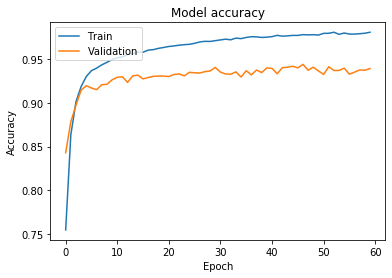

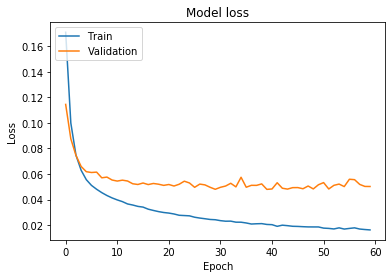

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Restore Weights

In [6]:
checkpoint_dir = './checkpoints/' + model_name
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [7]:
test_predict = model.predict(test_data.x)
print(test_predict.shape)

(6051, 1)




## Save Prediction to CSV

In [8]:
import csv

output_file = 'result_' + model_name + '.csv'
with open(output_file, 'wt', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(('Id', 'Predicted'))
    for id, predict in enumerate(test_predict):
        csv_writer.writerow((id, predict[0]))
print('Saved to '+'result_' + model_name + '.csv')

Saved to result_lstm_pooling.csv
